In [1]:
#https://dylancastillo.co/text-classification-using-python-and-scikit-learn/
#import packages
import pandas as pd
import numpy as np
import re
import string
import os
import emoji
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import shap


C:\Users\Wenlei\Anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from xgboost import XGBClassifier

In [4]:
#visualization related
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#log cannot hand negtive or 0, instead using some 

def logTransformer (df):
    return df.apply(lambda x : np.log(x+1))


log_transformer = FunctionTransformer(logTransformer)

In [6]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', str(input_text))
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', str(input_text))
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return str(input_text).replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return str(input_text).translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', str(input_text))
    
    def to_lower(self, input_text):
        return str(input_text).lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = str(input_text).split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = str(input_text).split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
#     def fill_blank_text (self, input_text):
#         empty_clean = input_text == ''
#         #print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
#         input_text.loc[empty_clean] = '[no_text]'
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [7]:
class OneDWrapper:
    """One dimensional wrapper for sklearn Transformers"""

    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(np.array(X).reshape(-1, 1))
        return self

    def transform(self, X, y=None):
        return self.transformer.transform(
            np.array(X).reshape(-1, 1)).ravel()

    def inverse_transform(self, X, y=None):
        return self.transformer.inverse_transform(
            np.expand_dims(X, axis=1)).ravel()

In [8]:

gs = load(r'.\pickle\handle_different_type.pickle')
type(gs)

sklearn.model_selection._search.RandomizedSearchCV

In [9]:
gs

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(func=<function logTransformer at 0x000002C8422BF280>)),
                                                                                               ('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                      

In [10]:
estimator = gs.best_estimator_
model = estimator.named_steps['classifier']
model.coef_.ravel() #153  total variable number

array([ 0.04684976,  4.875678  , -0.13266825, -0.03649512,  0.        ,
        0.        ,  0.        ,  0.        , -0.12349634,  0.04795618,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00893047,
       -0.09344842,  0.        ,  0.        ,  0.        ,  0.26283749,
       -0.04691911,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.68479338, -0.0916229 , -0.7460114 ,  0.        ,  0.        ,
       -0.02928438,  0.        ,  0.        , -0.47551124,  0.78372686,
        0.        , -2.54639447, -0.65597914,  0.14455008,  0.77047569,
        1.73882427,  0.10446189,  0.63460996,  0.65134207,  0.73139528,
       -0.75250951, -0.44833494,  0.8744729 ,  0.50824661,  1.21449664,
       -0.66021852,  1.90675898, -2.37810114,  0.        ,  0.        ,
       -0.3179332 , -0.46772572,  0.        , -0.23020288, -0.93404412,
       -0.35823765,  0.68217294,  0.        ,  0.27483472,  0.        ,
       -0.04494653,  1.14506355,  0.        ,  0.        ,  0.  

In [11]:
from sklearn import set_config
set_config(display="diagram")
estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function logTransformer at 0x000002C8422BF280>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Rating',
                                                   'Positive Feedback Count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[...
                                                                                               'اللتان',
                                                                                               'اللتيا',
                                                                                               'اللتين',
                                                                                               'اللذان',
                                                                                               'اللذين',
                                                                                               'اللواتي',
                                                                                               'إلى',
                                                                                               'إليك',
                                                                                               'إليكم',
                                                                                               'إليكما',
                                                                                               'إليكن',
                                                                                               'أم',
                                                                                               'أما',
                                                                                               'أما',
                                                                                               'إما',
                                                                                               'أن', ...])),
                                                                  ('selectkbest',
                                                                   SelectKBest(k=100,
                                                                               score_func=<function chi2 at 0x000002C83AD74670>)),
                                                                  ('tfidftransformer',
                                                                   TfidfTransformer())]),
                                                  'Review Text')])),
                ('classifier',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [12]:
num_column = ['Age',  'Rating', 'Positive Feedback Count' ]
txt_column = [ 'Title', 'Review Text'] 
#cat_column after one hot encoding, name is changed 
cat_column = ['Division Name', 'Department Name', 'Class Name']
cat_column_ohe = list( estimator.named_steps['preprocessor'].named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names())
cat_column_ohe


['x0_General',
 'x0_General Petite',
 'x0_Initmates',
 'x0_Missing',
 'x1_Bottoms',
 'x1_Dresses',
 'x1_Intimate',
 'x1_Jackets',
 'x1_Missing',
 'x1_Tops',
 'x1_Trend',
 'x2_Blouses',
 'x2_Dresses',
 'x2_Fine gauge',
 'x2_Intimates',
 'x2_Jackets',
 'x2_Jeans',
 'x2_Knits',
 'x2_Layering',
 'x2_Legwear',
 'x2_Lounge',
 'x2_Missing',
 'x2_Outerwear',
 'x2_Pants',
 'x2_Shorts',
 'x2_Skirts',
 'x2_Sleep',
 'x2_Sweaters',
 'x2_Swim',
 'x2_Trend']

In [13]:
estimator.named_steps['preprocessor'].named_transformers_['pipeline-3'].named_steps

{'onedwrapper': <__main__.OneDWrapper at 0x2c8426f3340>,
 'countvectorizer': CountVectorizer(stop_words=['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر',
                             'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي',
                             'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان',
                             'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم',
                             'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', ...]),
 'selectkbest': SelectKBest(k=20, score_func=<function chi2 at 0x000002C83AD74670>),
 'tfidftransformer': TfidfTransformer()}

In [14]:
#pipeline 3 handle 20 title text column
title_word_list =[]
for i in range(20):      #select 20 important word
    ix = estimator.named_steps['preprocessor'].named_transformers_['pipeline-3'].named_steps['selectkbest'].get_support(indices=True)[i]
    word= estimator.named_steps['preprocessor'].named_transformers_['pipeline-3'].named_steps['countvectorizer'].get_feature_names()[ix]
    title_word_list.append(word)
title_word_list = ['title_' + x for x in title_word_list] #add prefix to tell difference
title_word_list

['title_boxy',
 'title_comfortable',
 'title_comfy',
 'title_disappointed',
 'title_disappointing',
 'title_dress',
 'title_fall',
 'title_fun',
 'title_gorgeous',
 'title_great',
 'title_love',
 'title_perfect',
 'title_poor',
 'title_quality',
 'title_soft',
 'title_summer',
 'title_tee',
 'title_unflattering',
 'title_unique',
 'title_wanted']

In [15]:
len(title_word_list)

20

In [16]:
#pipeline 4 handle review text column
review_word_list =[]
for i in range(100):      #select 100 important word
    ix = estimator.named_steps['preprocessor'].named_transformers_['pipeline-4'].named_steps['selectkbest'].get_support(indices=True)[i]
    word= estimator.named_steps['preprocessor'].named_transformers_['pipeline-4'].named_steps['countvectorizer'].get_feature_names()[ix]
    review_word_list.append(word)
review_word_list = ['review_' + x for x in review_word_list] #add prefix to tell difference
review_word_list

['review_add',
 'review_amaz',
 'review_appear',
 'review_arriv',
 'review_aw',
 'review_awkward',
 'review_back',
 'review_bad',
 'review_bit',
 'review_black',
 'review_boot',
 'review_bought',
 'review_boxi',
 'review_casual',
 'review_cheap',
 'review_classic',
 'review_comfi',
 'review_comfort',
 'review_complet',
 'review_compliment',
 'review_detail',
 'review_disappoint',
 'review_easi',
 'review_enough',
 'review_even',
 'review_excit',
 'review_fabric',
 'review_fall',
 'review_felt',
 'review_feminin',
 'review_fit',
 'review_fun',
 'review_glad',
 'review_got',
 'review_great',
 'review_green',
 'review_happi',
 'review_heel',
 'review_highli',
 'review_horribl',
 'review_howev',
 'review_huge',
 'review_hung',
 'review_idea',
 'review_jacket',
 'review_jean',
 'review_like',
 'review_littl',
 'review_look',
 'review_love',
 'review_made',
 'review_mani',
 'review_materi',
 'review_matern',
 'review_mayb',
 'review_model',
 'review_much',
 'review_navi',
 'review_nice',
 'r

In [17]:
column_name = num_column + cat_column_ohe + title_word_list + review_word_list
len(column_name)

153

In [18]:
df_featureimportance = pd.DataFrame(list(zip(column_name, model.coef_.ravel())), columns = ['name', 'coef']).sort_values(by=['coef'], ascending=False)

In [19]:
df_featureimportance.head(10)

,name,coef
1,Rating,4.875678
51,title_unique,1.906759
40,title_fun,1.738824
49,title_tee,1.214497
66,review_casual,1.145064
88,review_green,1.099194
133,review_size,0.986468
86,review_got,0.913488
97,review_jacket,0.877559
47,title_soft,0.874473


In [54]:
df_featureimportance.tail(10)

,name,coef
59,review_back,-0.934044
94,review_huge,-1.106909
101,review_look,-1.196203
74,review_disappoint,-1.241194
123,review_return,-1.345431
106,review_matern,-1.496511
130,review_seem,-1.549178
127,review_sadli,-1.824847
52,title_wanted,-2.378101
36,title_disappointed,-2.546394


Text(0.5, 1.0, 'Top 20 important features ')

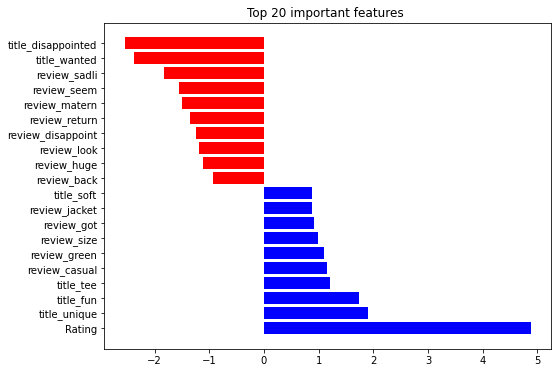

In [61]:
#show top10 and bottom 10 in  chart
df_chart = pd.concat([df_featureimportance.head(10),df_featureimportance.tail(10)])
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

# Example data
y_pos = np.arange(len(df_chart.coef))
ax.barh(y_pos, df_chart.coef,  align='center' , color=np.where(df_chart.coef < 0, 'red', 'blue'),)
ax.set_yticks(y_pos)
ax.set_yticklabels(df_chart.name)
ax.set_title('Top 20 important features ')
 

In [ ]:
#permutation importance 

In [22]:
#above are using the data in the model, now need the data for calculation
df = pd.read_csv (r'C:\Users\Wenlei\Desktop\blog51\Womens Clothing E-Commerce Reviews.csv').drop(columns = 'Unnamed: 0')
df1_undersample = df[df['Recommended IND']==1].sample(4172, random_state = 42)
df_undersample  = pd.concat([df1_undersample, df[df['Recommended IND']==0]])
X =  df_undersample.drop(['Clothing ID','Recommended IND'], axis =1)
y =  df_undersample['Recommended IND']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.metrics import f1_score
y_pred = gs.predict(X_test)
full_f1_score = f1_score(y_test, y_pred)
full_f1_score

0.9396135265700483

In [39]:
#https://towardsdatascience.com/from-scratch-permutation-feature-importance-for-ml-interpretability-b60f7d5d1fe9

# Initialize a list of results
results = []
# Iterate through each predictor
for predictor in X_test:
    
    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values  #shuffle
    
    # Calculate the new RMSE
    new_f1_score = f1_score(y_test,gs.predict(X_test_copy))
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': full_f1_score - new_f1_score })
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)
resultsdf

,pred,score
3,Rating,0.423446
2,Review Text,0.003469
1,Title,0.003392
7,Class Name,0.000567
0,Age,0.000000
4,Positive Feedback Count,0.000000
5,Division Name,0.000000
6,Department Name,0.000000


In [ ]:
#

In [57]:
'''  Test code
import re
#create a mapping dictionary
column_filter_mapping  = {'Age':'Age',  'Rating':'Rating', 'Positive Feedback Count':'Positive Feedback Count',
                            'Division Name':'x0_.', 'Department Name':'x1_.', 'Class Name':'x2_.', 
                          'Title':'title_.', 'Review Text':'review_.' } 
column_group_mapping = {}

for k, v in column_filter_mapping.items():
    p = re.compile(v) #loop through the pattern
    l= [ s for s in column_name if p.match(s) ] #get list of column satisfied the pattern
    column_group_mapping.update({k:l}) #add to new dict
column_group_mapping

# Initialize a list of results
results = []
# Iterate through each predictor
for predictor, columns in column_group_mapping.items():
    
    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[columns] = X_test[columns].sample(frac=1).values  #shaffle
    
    # Calculate the new RMSE
    new_f1_score = f1_score(y_test,gs.predict(X_test_copy))
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': full_f1_score - new_f1_score })
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)
resultsdf 
'''

"\nimport re\n#create a mapping dictionary\ncolumn_filter_mapping  = {'Age':'Age',  'Rating':'Rating', 'Positive Feedback Count':'Positive Feedback Count',\n                            'Division Name':'x0_.', 'Department Name':'x1_.', 'Class Name':'x2_.', \n                          'Title':'title_.', 'Review Text':'review_.' } \ncolumn_group_mapping = {}\n\nfor k, v in column_filter_mapping.items():\n    p = re.compile(v) #loop through the pattern\n    l= [ s for s in column_name if p.match(s) ] #get list of column satisfied the pattern\n    column_group_mapping.update({k:l}) #add to new dict\ncolumn_group_mapping\n\n# Initialize a list of results\nresults = []\n# Iterate through each predictor\nfor predictor, columns in column_group_mapping.items():\n    \n    # Create a copy of X_test\n    X_test_copy = X_test.copy()\n    \n    # Scramble the values of the given predictor\n    X_test_copy[columns] = X_test[columns].sample(frac=1).values  #shaffle\n    \n    # Calculate the new RMSE\

In [27]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

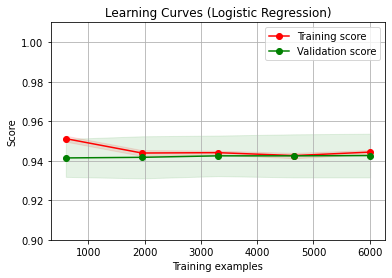

In [62]:

title = 'Learning Curves (Logistic Regression)'
cv = 10
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.9, 1.01), cv= cv, n_jobs =1);

In [ ]:
#to check if it is overfitting or underfitting
'''
Learning curves allow us to diagnose if the is overfitting or underfitting.
not underfit, because score is high
not overfitting
'''

In [ ]:
#no sign of over/under fitting, both are high

In [36]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator= estimator, X= X, y= y, param_name =param_name, param_range = param_range, cv=cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

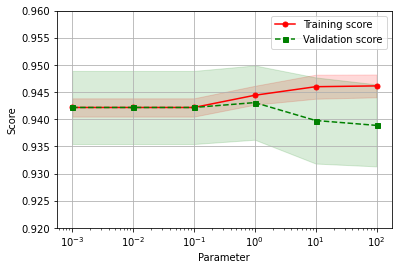

In [37]:
title = 'Validation Curve (Logistic Regression)'
param_name = 'classifier__C'  #estimator.get_params().keys()
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=estimator, title=title, X=X_train, y=y_train, 
                      param_name=param_name, ylim=(0.92, 0.96), param_range=param_range);

In [ ]:
#the validation curve able to drop, edge of overfitting
#use to check hyperparam, see 10_1 get high also,no gap, gap indicate overfitting

In [ ]:
#get final model
#https://stackoverflow.com/questions/71140633/how-to-save-the-best-estimator-in-gridsearchcv

#cross val score
#https://stackoverflow.com/questions/70316221/difference-between-gridsearchcv-and-cross-val-score

#Bayesian Hyperparameter Optimization methods


In [ ]:
#distribution  curve
#AUC
#feature importance shap

In [38]:
#distribuation
result_prob = estimator.predict_proba(X_test)
df_test = pd.DataFrame(result_prob, columns= estimator.classes_) 
df_test

,0,1
0,0.815418,0.184582
1,0.814765,0.185235
2,0.995940,0.004060
3,0.008487,0.991513
4,0.760321,0.239679
...,...,...
1664,0.051040,0.948960
1665,0.685191,0.314809
1666,0.997727,0.002273
1667,0.034740,0.965260


In [45]:
df_test[1]

0       0.184582
1       0.185235
2       0.004060
3       0.991513
4       0.239679
          ...   
1664    0.948960
1665    0.314809
1666    0.002273
1667    0.965260
1668    0.112776
Name: 1, Length: 1669, dtype: float64

In [27]:
df_distr = pd.DataFrame(zip(df_test[1], y_test ), columns = ['prob',  'actual'])
df_distr

,prob,actual
0,0.184582,0
1,0.185235,0
2,0.004060,0
3,0.991513,1
4,0.239679,0
...,...,...
1664,0.948960,1
1665,0.314809,0
1666,0.002273,0
1667,0.965260,1


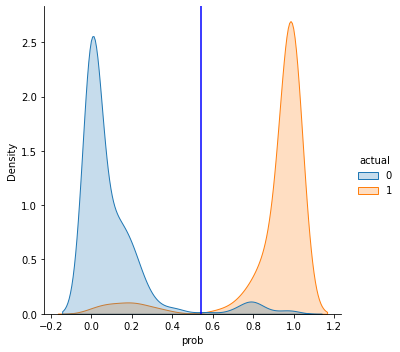

In [32]:
#best threshold is 0.54
g1 = sns.displot(df_distr, x = 'prob', hue = 'actual', kind = 'kde',fill= True)
#g.ax.set_yscale('log') 
plt.axvline(x = 0.54, color = 'b', label = 'axvline - full height')

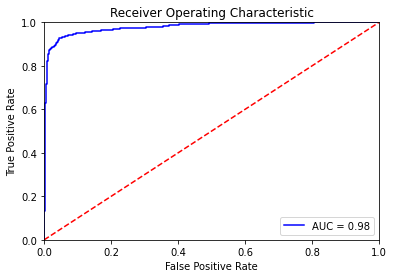

In [35]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#ROC curve
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = estimator.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=column_names, plot_type='bar')

In [ ]:
#https://learn.microsoft.com/en-us/analysis-services/data-mining/lift-chart-analysis-services-data-mining?view=asallproducts-allversions

In [36]:
import scikitplot as skplt

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

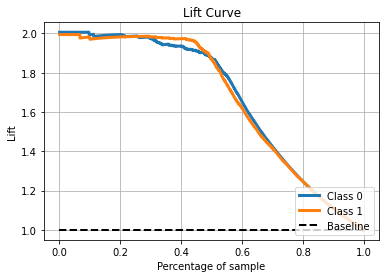

In [44]:
#https://scikit-plot.readthedocs.io/en/stable/metrics.html
#http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html
skplt.metrics.plot_lift_curve(y_test, df_test[[0, 1]])

In [17]:
y_test

12478    0
5805     0
675      0
1907     1
6972     0
        ..
17000    1
14294    0
20770    0
18684    1
7769     0
Name: Recommended IND, Length: 1669, dtype: int64